# 🐝 Overview of the Xylo family

*Xylo* is a family of spiking neural network ASICs, for efficient simulation of spiking leaky integrate-and-fire neurons with exponential input synapses.
Xylo is highly configurable, and supports individual synaptic and membrane time-constants, thresholds and biases for each neuron.
Xylo supports arbitrary network architectures, including recurrent networks, residual spiking networks, and more.

Xylo is currently available in several versions with varying HW support and front-ends.

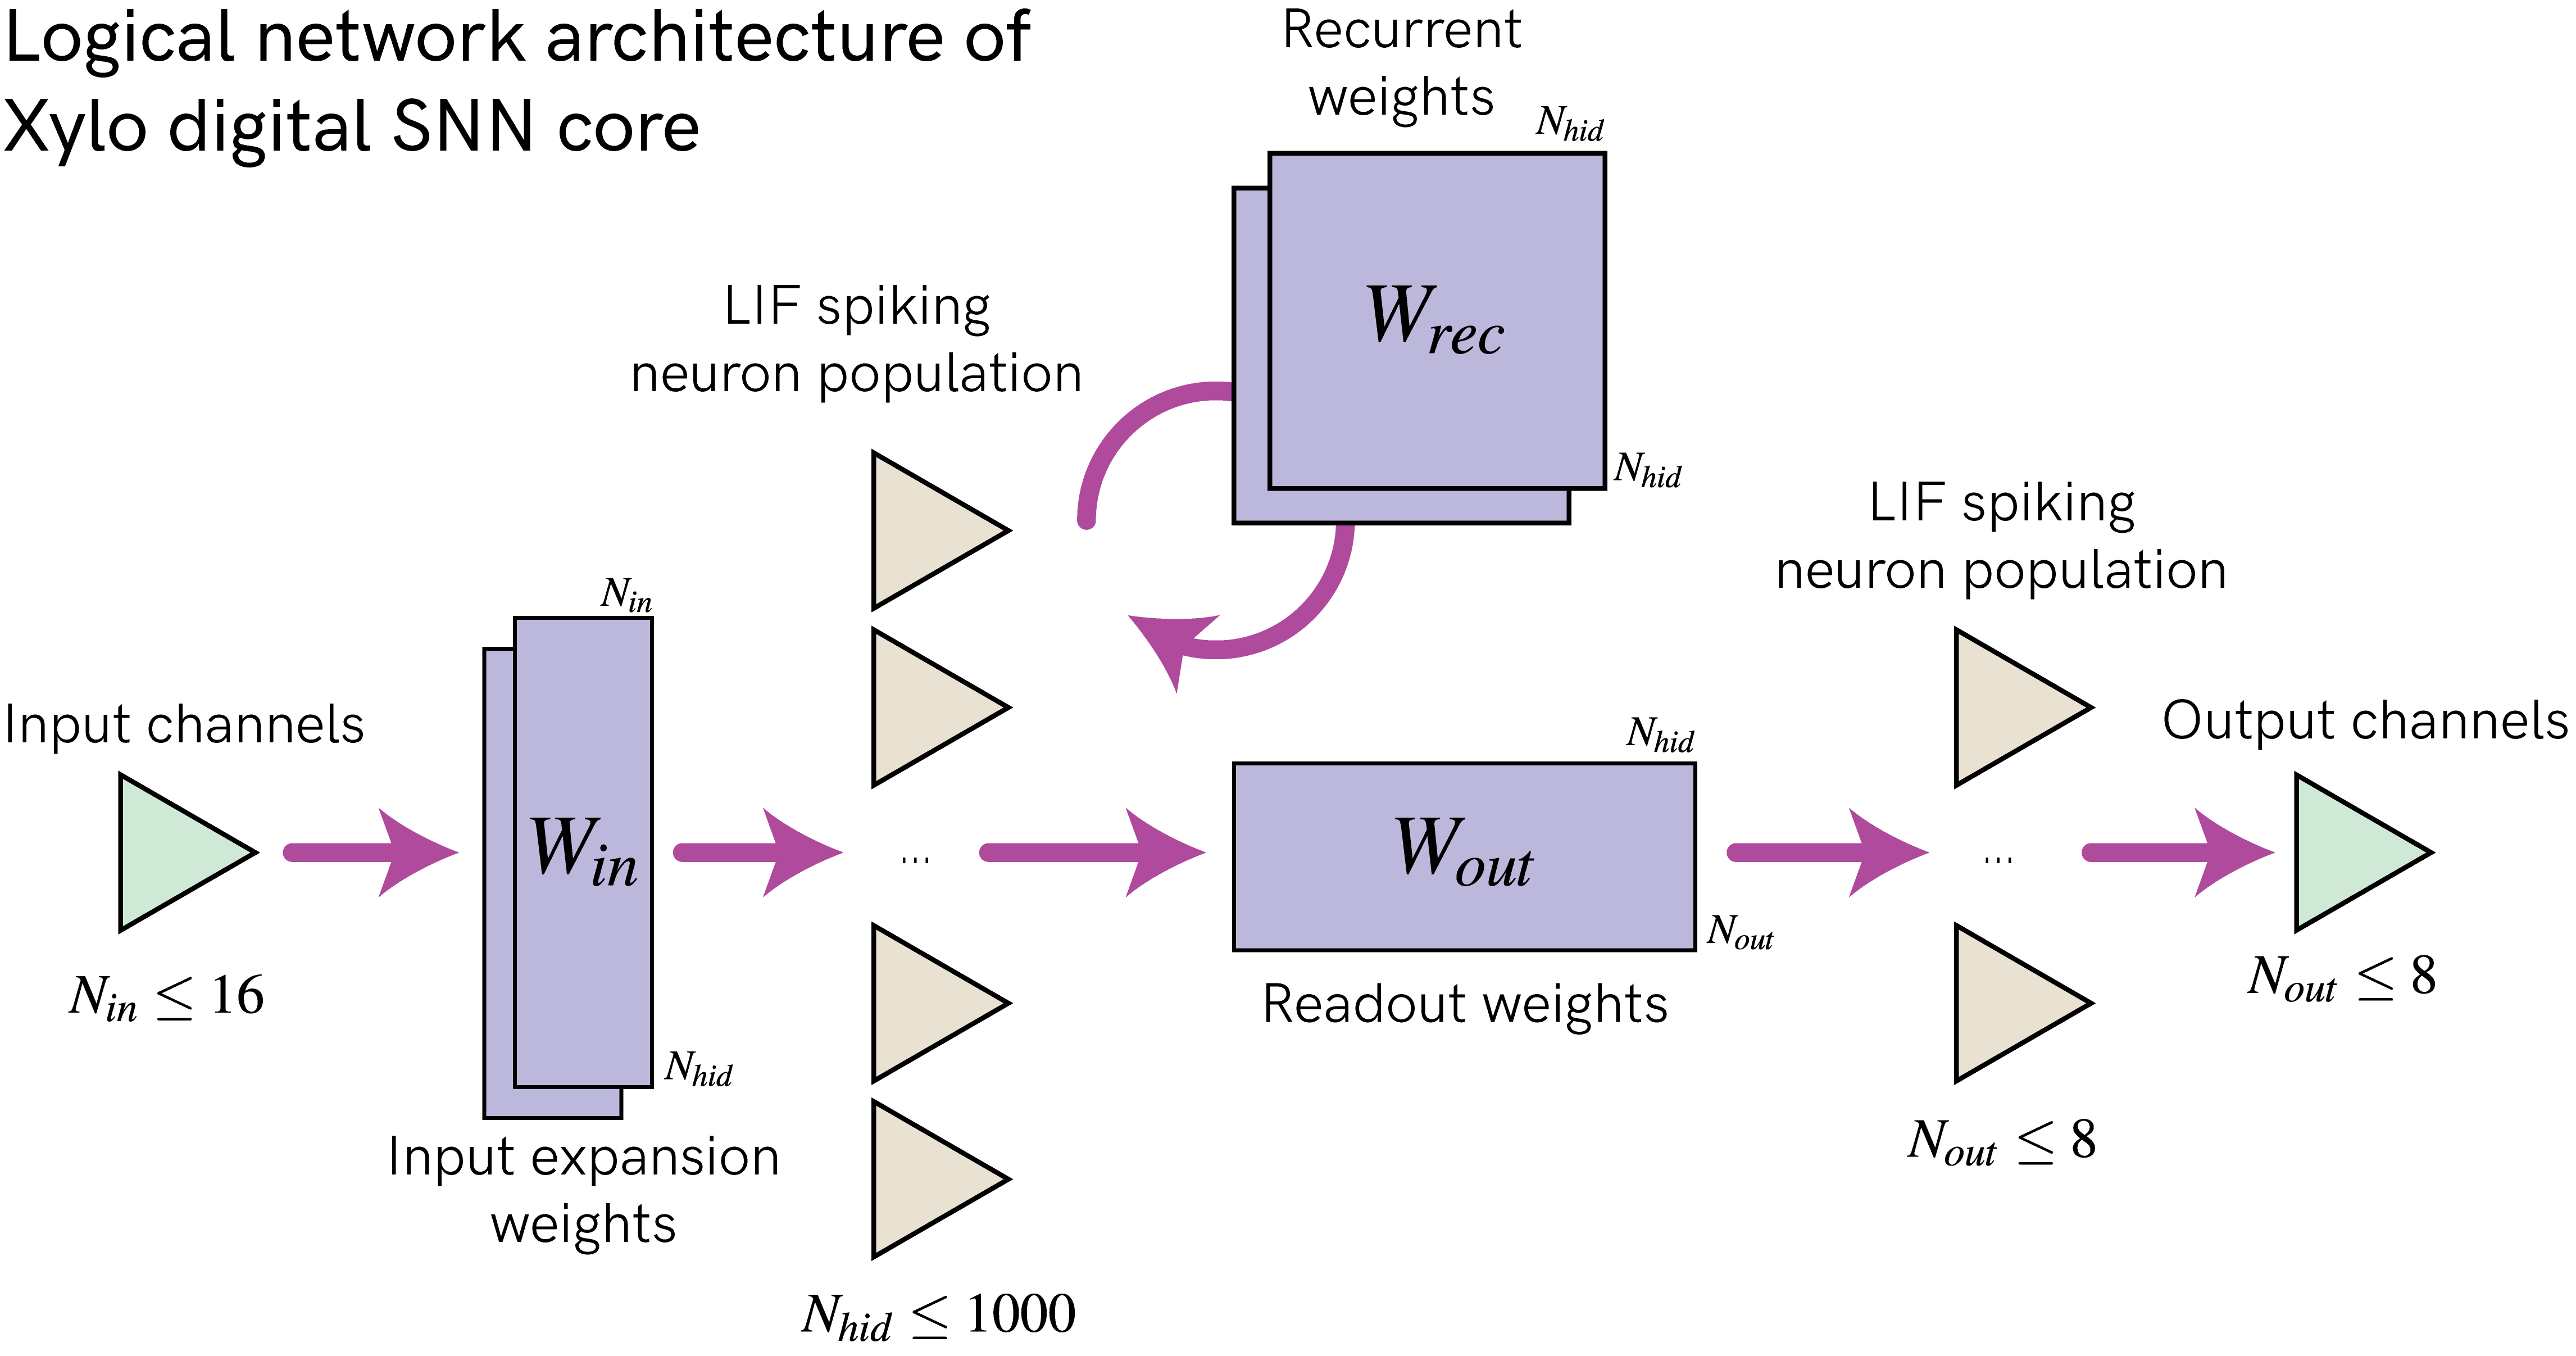

In [1]:
# - Image display
from IPython.display import Image

Image("images/xylo_network-architecture.png")

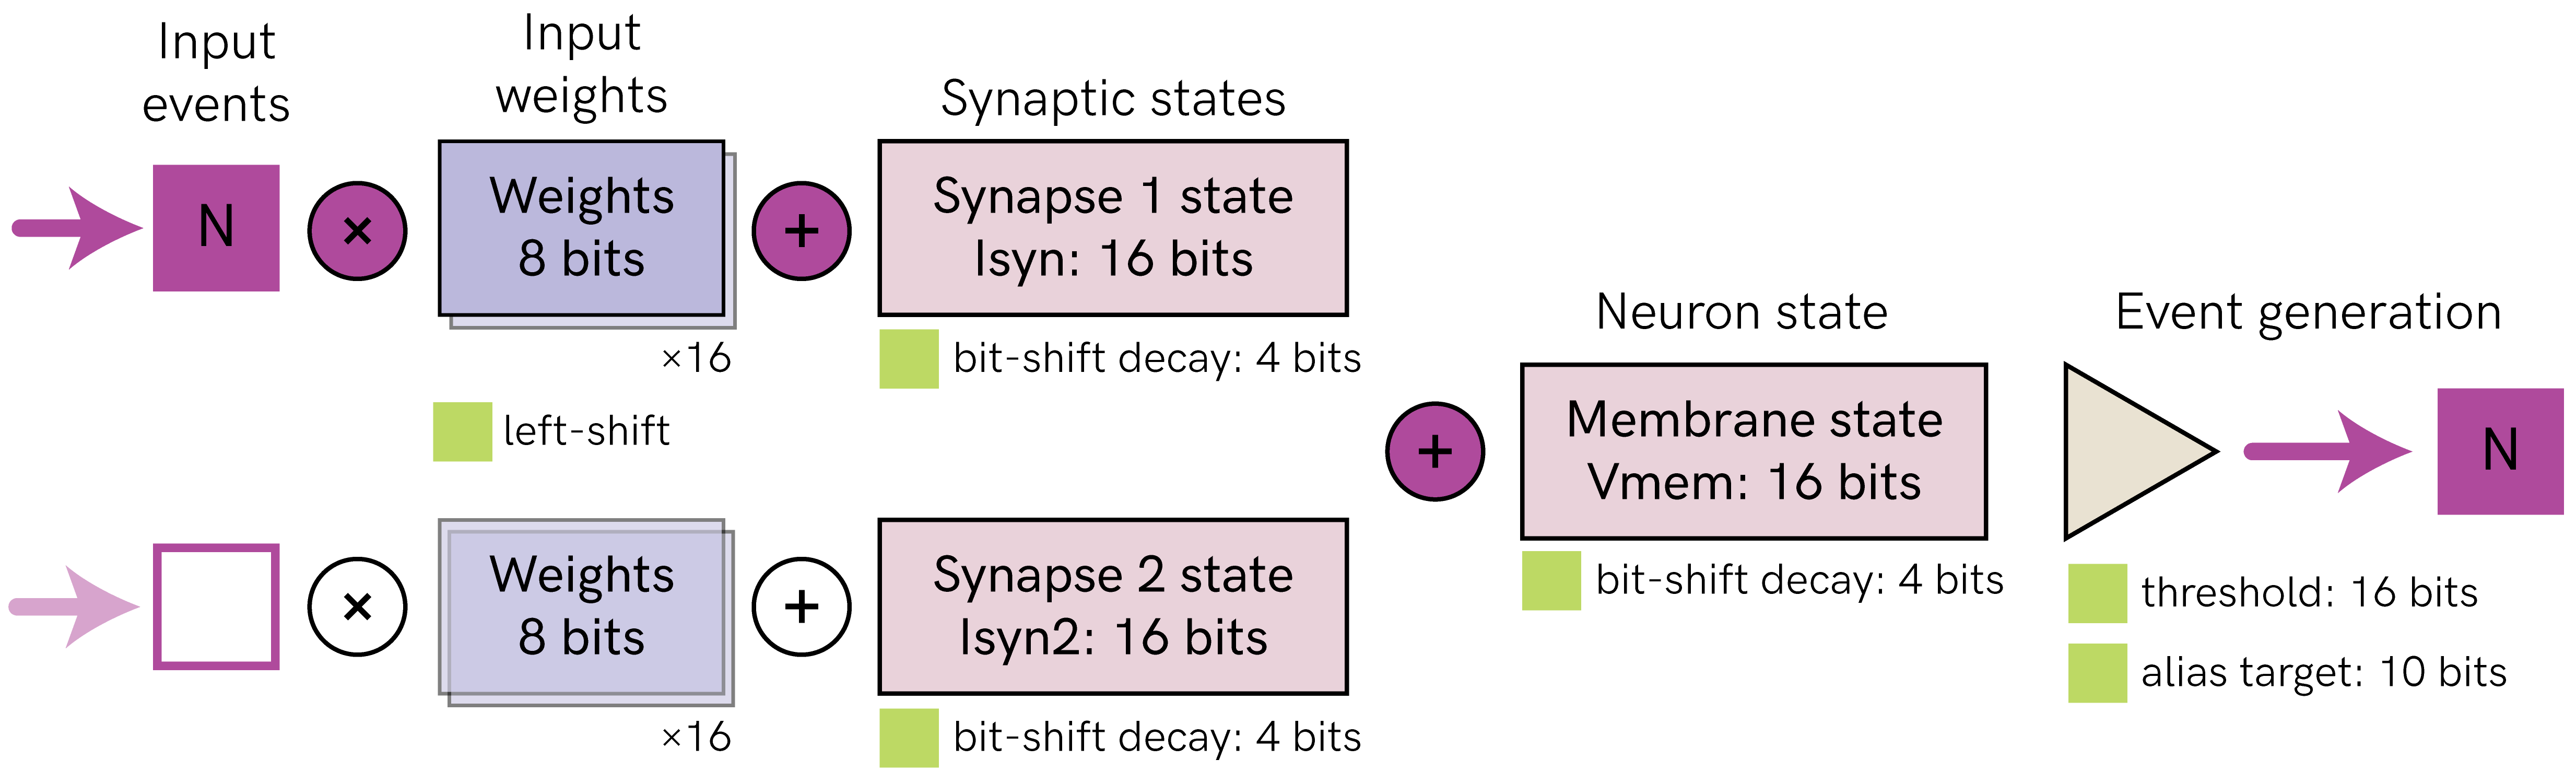

In [2]:
Image("images/xylo_neuron-model.png")

In [3]:
# - Switch off warnings
import warnings

warnings.filterwarnings("ignore")

# - Useful imports
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

try:
    from rich import print
except:
    pass

import numpy as np

## Bit-shift decay

Xylo devices simulate exponential decay using an efficient bit-shift-subtraction technique. Consequently, time constants are expressed as "bit-shift decay" parameters ("dash" parameters) which are a function of the fixed simulation time-step. The equation for that conversion is:

$dash = [\log_2(\tau / dt)]$

Hence, the dash parameter for a synapse with a 2 ms time constant, with a simulation resolution of 1 ms, is ``1``.

But what is done with this bitshift of 1? Let's compare exponential decay with bitshift decay. The bit-shifting decay method is illustrated by the function ``bitshift()`` below.

In [4]:
def bitshift(value: int, dash: int) -> int:
    # - Bit-shift decay
    new_value = value - (value >> dash)

    # - Linear decay below dash-driven change
    if new_value == value:
        new_value -= 1

    return new_value

As you can see, the bit-shifting decay is accomplished by the line

$v' = v - (v >> dash)$

where $>>$ is the right-bit-shift operator; $v$ is the current value and $v'$ is the new value after the bit-shifting step. Since $v$ is an integer, for low values of $v$, $v >> dash = 0$. We therefore perform a linear decay for low values of $v$.

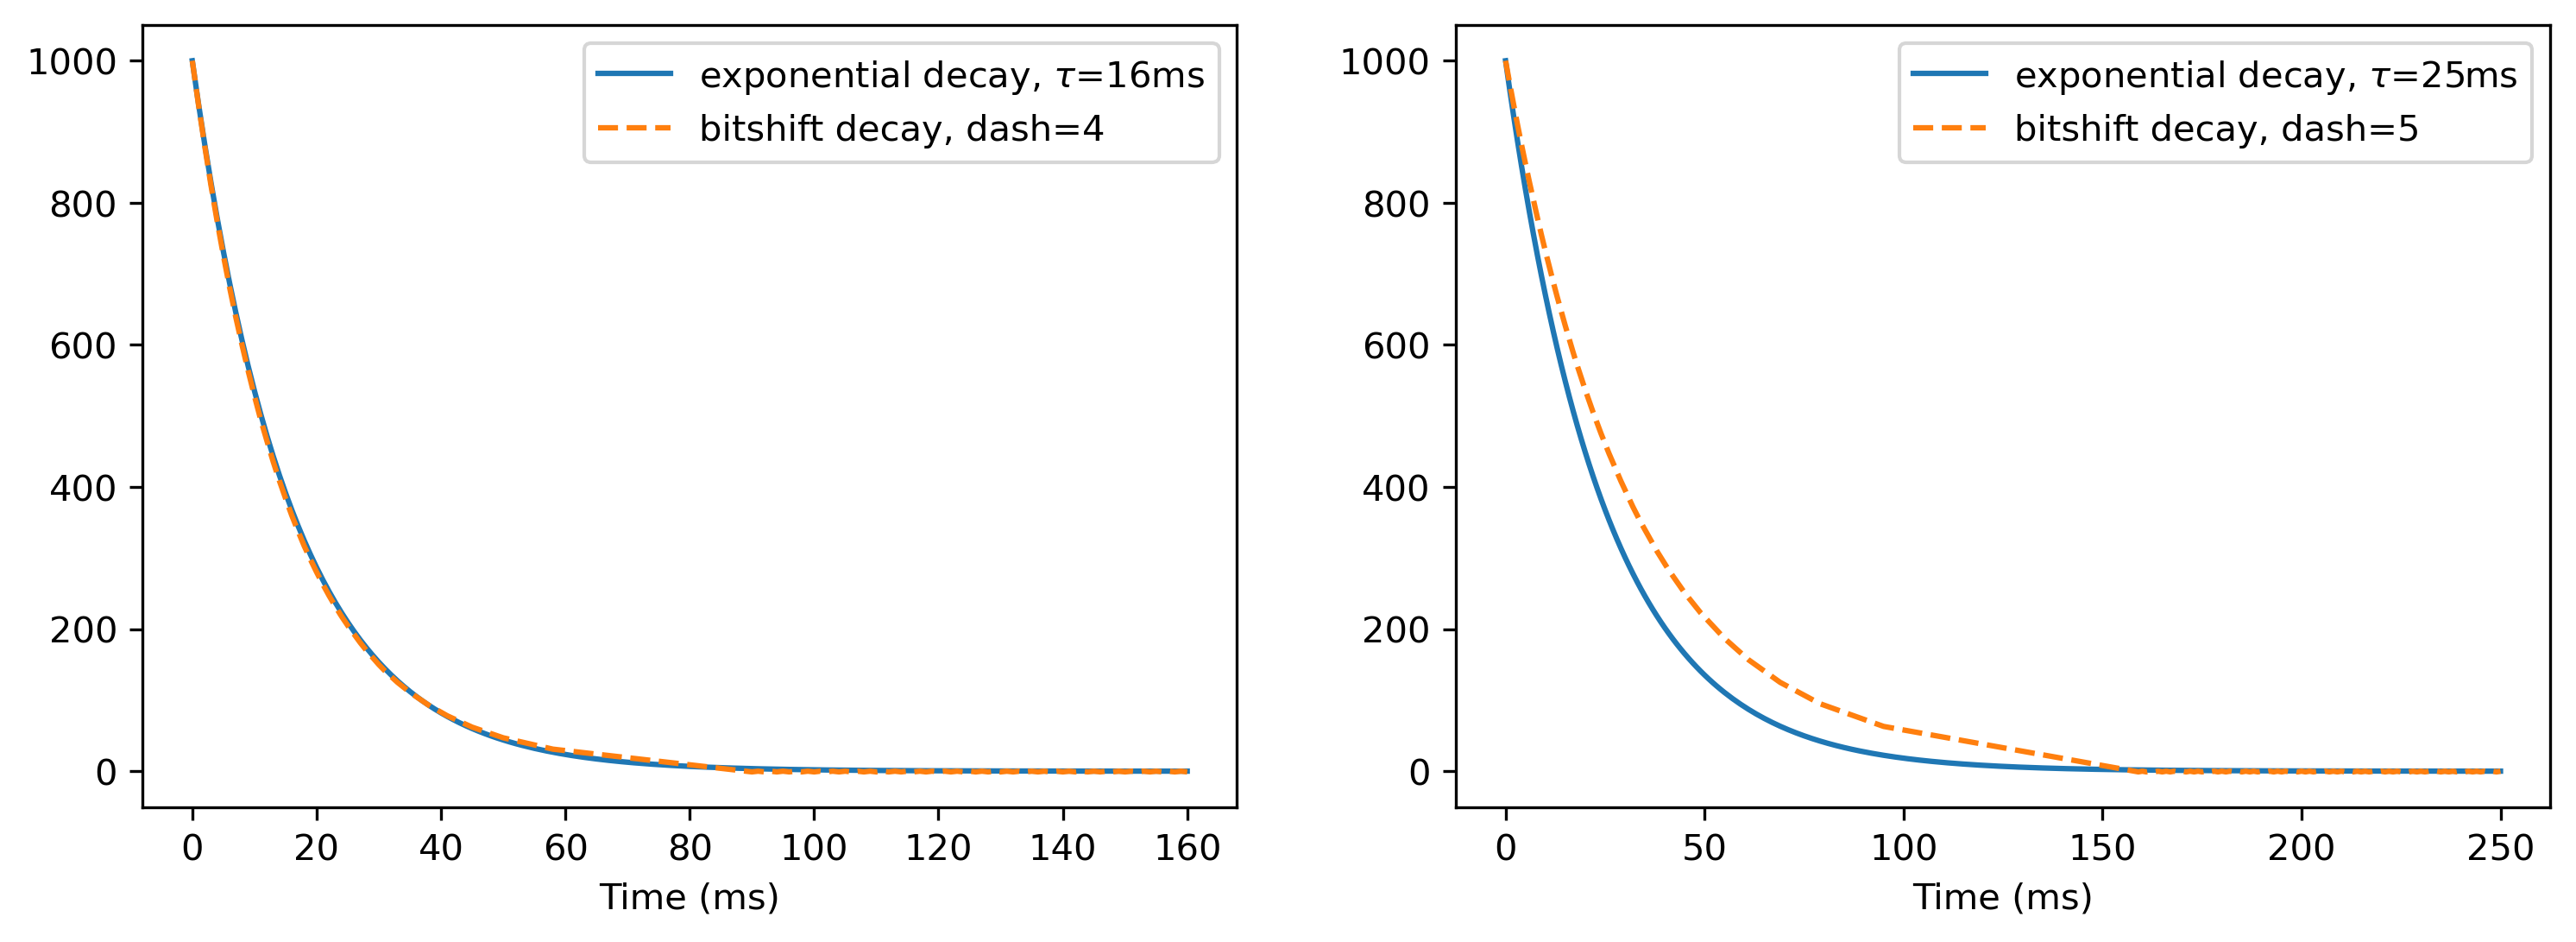

In [5]:
def plot_tau_dash(tau: float, dt_: float = 1e-3, simtime: float = None):
    if simtime is None:
        simtime = tau * 10.0

    # - Compute dash, and the exponential propagator per time-step
    dash = np.round(np.log2(tau / dt_)).astype(int)
    exp_propagator = np.exp(-dt_ / tau)

    # - Compute exponential and dash decay curves over time
    t_ = 0
    v_tau = [1000]
    v_dash = [1000]
    while t_ < simtime:
        v_tau.append(v_tau[-1] * exp_propagator)
        v_dash.append(bitshift(v_dash[-1], dash))
        t_ += dt_

    # - Plot the two curves for comparison
    plt.plot(
        np.arange(0, len(v_tau)) * dt_ * 1e3,
        v_tau,
        label=f"exponential decay, $\\tau$={int(tau * 1e3)}ms",
    )
    plt.plot(
        np.arange(0, len(v_dash)) * dt_ * 1e3,
        v_dash,
        "--",
        label=f"bitshift decay, dash={dash}",
    )
    plt.legend()
    plt.xlabel("Time (ms)")


# - Plot examples for tau = 16ms and tau = 25 ms
plt.figure()
plt.subplot(1, 2, 1)
plot_tau_dash(16e-3)

plt.subplot(1, 2, 2)
plot_tau_dash(25e-3)

For powers of two, the approximation is very close. But since this is integer arithmetic, the approximation will not always be perfect. We can see this with the example of $\tau = 25$ms.

## Next steps